# 조건부 오토인코더 (TensorFlow 2)

In [ ]:
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt
 
print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.

2.4.1
2.4.0


## MNIST 데이터셋 

In [ ]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images의 *원래* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *원래* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

# Normalizing the images to the range of [0., 1.]
train_images = tf.cast(train_images, tf.float32)
test_images  = tf.cast(test_images, tf.float32)
train_images /= 255
test_images  /= 255

print('train_images의 *바뀐* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *바뀐* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)


# Print out for checking
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels.dtype)

train_images의 *원래* 데이터의 shape과 dype: (60000, 28, 28) uint8
test_images의 *원래* 데이터의 shape과 dype: (10000, 28, 28) uint8
train_images의 *바뀐* 데이터의 shape과 dype: (60000, 28, 28) <dtype: 'float32'>
test_images의 *바뀐* 데이터의 shape과 dype: (10000, 28, 28) <dtype: 'float32'>
(28, 28)
<dtype: 'float32'>
uint8


In [ ]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

# 데이터 변환 확인
print(train_label_onehots.shape)
print(test_label_onehots.shape)

print(train_label_onehots[0])
print(train_labels[0])
print(test_label_onehots[0])
print(test_labels[0])

(60000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


In [ ]:
n_dim = 2

In [ ]:
enc_img = tf.keras.Input(shape = (28,28), name = 'enc_image_input')
enc_con = tf.keras.Input(shape = (10,), name = 'enc_condition_input')

enc_dense_1 = tf.keras.layers.Dense(256, activation='relu')
enc_dense_2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense_3 = tf.keras.layers.Dense( 32, activation='relu')
enc_dense_4 = tf.keras.layers.Dense(n_dim)

flat_img = tf.keras.layers.Flatten()(enc_img)
x = tf.keras.layers.concatenate([flat_img, enc_con])
x = enc_dense_1(x)
x = enc_dense_2(x)
x = enc_dense_3(x)
z = enc_dense_4(x)

cae_encoder = tf.keras.Model(inputs = [enc_img,enc_con], outputs = z, name = 'encoder')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_image_input (InputLayer)    [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           enc_image_input[0][0]            
__________________________________________________________________________________________________
enc_condition_input (InputLayer [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 794)          0           flatten_2[0][0]                  
                                                                 enc_condition_input[0][0]  

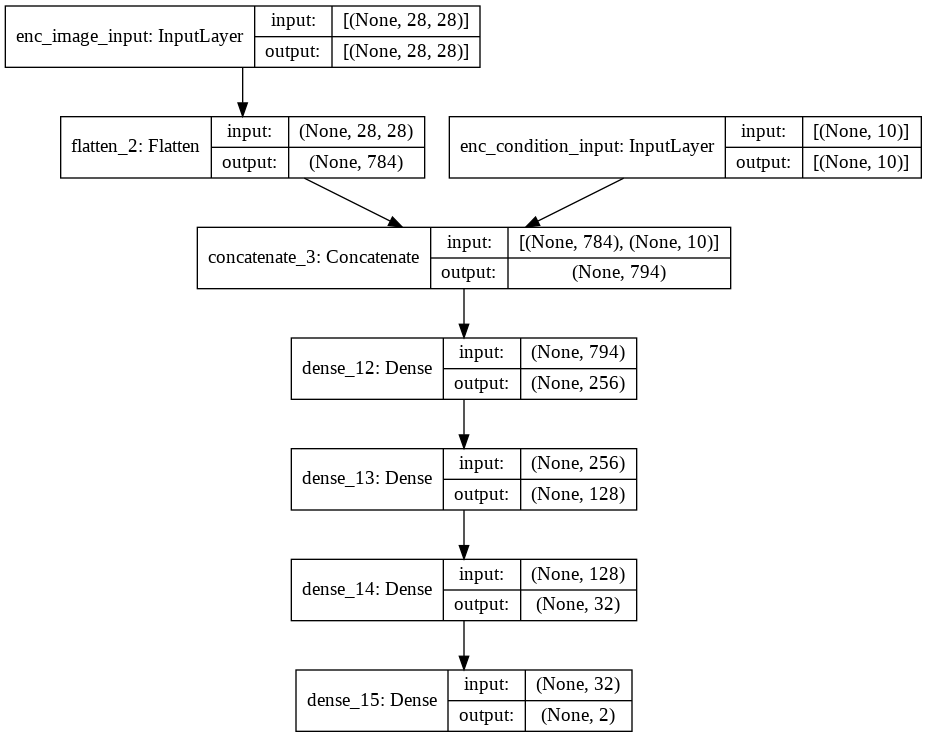

In [ ]:
cae_encoder.summary()
tf.keras.utils.plot_model(cae_encoder, show_shapes=True)

In [ ]:
dec_z = tf.keras.Input(shape = (2,), name = 'dec_z_input')

dec_dense_1 = tf.keras.layers.Dense( 32, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(784, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))

x = tf.keras.layers.concatenate([dec_z, enc_con])
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

cae_decoder = tf.keras.Model(inputs = [dec_z, enc_con], outputs = y_pred, name = 'decoder')

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_z_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
enc_condition_input (InputLayer [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 12)           0           dec_z_input[0][0]                
                                                                 enc_condition_input[0][0]        
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 32)           416         concatenate_5[0][0]        

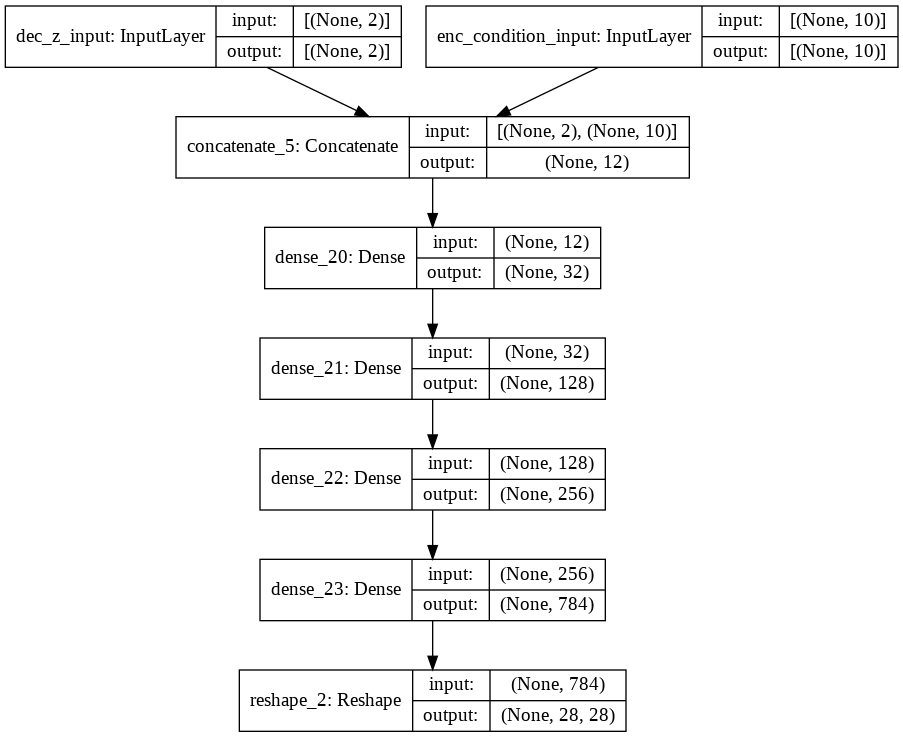

In [ ]:
cae_decoder.summary()
tf.keras.utils.plot_model(cae_decoder, show_shapes=True)

In [ ]:
encoder_out = cae_encoder([enc_img, enc_con])
decoder_out = cae_decoder([encoder_out,enc_con])
cae = tf.keras.Model([enc_img,enc_con], decoder_out , name = 'CAE')

Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_image_input (InputLayer)    [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
enc_condition_input (InputLayer [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2)            240610      enc_image_input[0][0]            
                                                                 enc_condition_input[0][0]        
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28)       239152      encoder[0][0]                  

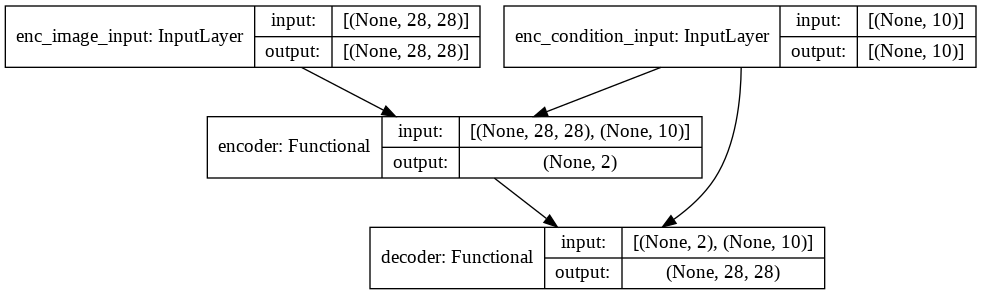

In [ ]:
cae.summary()
tf.keras.utils.plot_model(cae, show_shapes=True)

- 모델이 기존에 강의시간에서 배운 Conditional AutoEncoder와 동일한 것을 확인할 수 있다.

## 훈련 전, 네트워크 모델을 함수로서 활용

In [ ]:
results = cae([train_images, train_label_onehots])

print('input shape:', train_images.shape)
print('output shape:', results.shape)

input shape: (60000, 28, 28)
output shape: (60000, 28, 28)


In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 오토인코더 인스턴스 트레이닝

In [ ]:
cae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [ ]:
epochs = 20
batch_size = 128
cae.fit([train_images, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0773 - mae: 0.1627
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0407 - mae: 0.0963
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0373 - mae: 0.0890
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0358 - mae: 0.0860
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0349 - mae: 0.0843
Epoch 6/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0341 - mae: 0.0828
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0338 - mae: 0.0821
Epoch 8/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0333 - mae: 0.0812
Epoch 9/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0330 - mae: 0.0805
Epoch 10/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0329 - mae: 0.0804
Epoch 11/20
469/469 [============================

## 트레이닝이 끝난 오토인코더를 이용하기

In [ ]:
results = cae([train_images, train_label_onehots])

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(results[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 디코더를 이용한 Generative Model 구성

디코더 모델을 따로 생성하였기 때문에 전체 Conditional AutoEncoder가 학습을 끝내면 활용 가능하다.

In [ ]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) # ground truth : 4 라는 condition을 부여
  print(z_test)

  img_gen = cae_decoder([z_test, c_test])
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- z값을 조절하여 4를 만들어 낼 수 있다 ! 

## 인코딩 결과 가시화
오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다.
이 또한 기존에 encoder decoder class를 구분해 학습을 시켜 모델 그대로 사용 가능


In [ ]:
z = cae_encoder([train_images,train_label_onehots])
print(np.shape(z))

(60000, 2)


In [ ]:
def z_show(idx):
  print(z[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

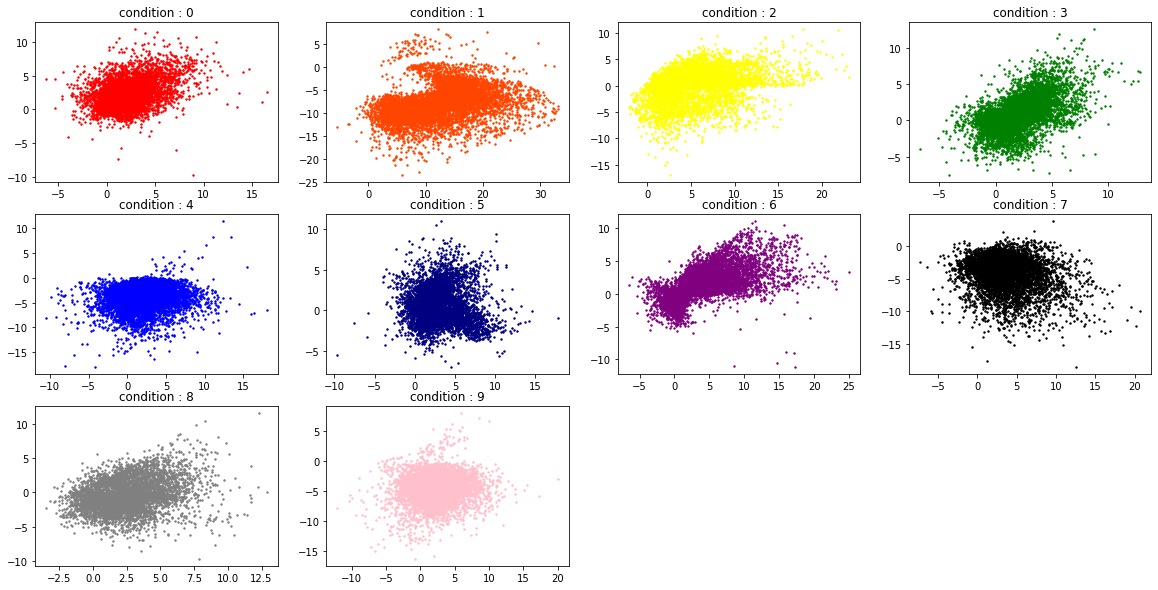

In [ ]:
z_0 = z[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('condition : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('condition : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('condition : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('condition : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('condition : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('condition : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('condition : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('condition : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('condition : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('condition : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

- 결과를 확인해보면 이전 과제인 AutoEncoder와 다르게 각 condition에 대한 latent vector의 분포가 0을 기준으로 퍼져 나가 있는 것을 확인할 수 있다. 하지만 condition = 1 인 데이터에 대해서는 latent vector가 다른 condition에 비해 퍼져있는 정도가 다르기 때문에 condition = 1 에 대해서는 잘 생성할지 의문이 든다.

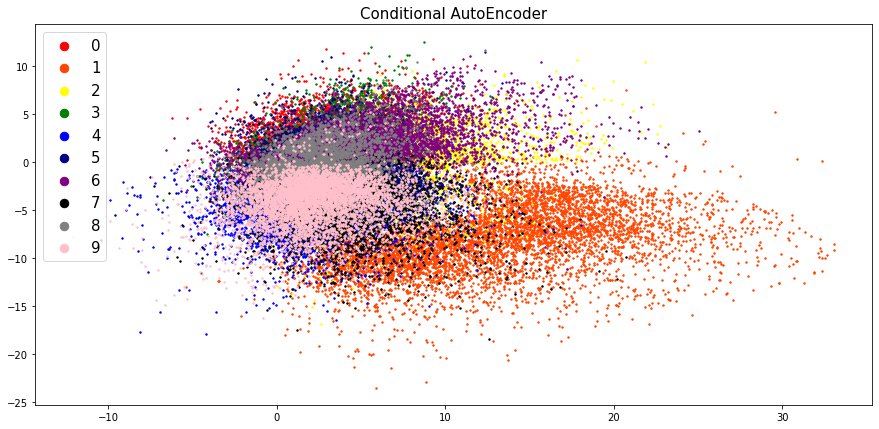

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Conditional AutoEncoder', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- 전체적인 시각화를 살펴보면 주황색인 condition = 1 을 제외하고는 어느정도 분포가 모여 있는것을 확인할 수 있다. 즉, 우리가 원하는 label 값을 condition으로 주면 어느정도 안정적으로 생성할 수 있다는 것을 의미한다.

- Convolution layer를 사용하기 위해서는 input 이미지가 3차원이 되어야한다. 현재 1차원인 one_hot_label을 3차원으로 변경하여 만약, label = 0 일 경우 (28,28,10) 에 대하여 1번째 channels의 값들을 다 1로 나머지는 0으로 채우도록 데이터를 reshape한다. 그 후 train_image와 concat을 하여 image dataset을 생성한다. 즉, 최종 데이터셋 shape은(60000, 28, 28, 11) (원본 이미지 : (60000,28,28,1) + condition : (60000, 28, 28, 10) 

In [ ]:
# ground true : 0 인 one hot label = [1,0,0,0,0,0,0,0,0,0] 를 28*28 번 반복해준다. 즉 [1,0,0,0,0,0,0,0,0,0,1,0,0 ~ 0] 이렇게 변환한 다음에 reshape을 통하여 원하는 channels에만 1의 값을 가지도록 함.
test = np.tile(train_label_onehots[1], 28*28).reshape(28,28,10)  # train_label_onehots[1] 의 GT label = 0이다.

print('Channel 0 shape : ', test[:,:,0].shape, '\n''Channel 0 value : \n',test[:,:,0])
print('Channel 1 shape : ', test[:,:,1].shape, '\n''Channel 1 value : \n',test[:,:,1])

Channel 0 shape :  (28, 28) 
Channel 0 value : 
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
# 위의 방법을 전체 데이터셋에 적용을 해준다.
train_label_onehots_dim = np.tile(train_label_onehots, 28*28).reshape(60000,28,28,10)

print('Channel 0 shape : ', train_label_onehots_dim[1,:,:,0].shape, '\n''Channel 0 value : \n',train_label_onehots_dim[1,:,:,0])
print('Channel 1 shape : ', train_label_onehots_dim[1,:,:,1].shape, '\n''Channel 1 value : \n',train_label_onehots_dim[1,:,:,1])
print("\n\n")
print('One hot label shape : ', train_label_onehots_dim.shape )

Channel 0 shape :  (28, 28) 
Channel 0 value : 
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
# 새롭게 데이터셋을 정의한다.

train_images_con = tf.concat([tf.reshape(train_images,(60000,28,28,1)), train_label_onehots_dim], axis = -1)
print(train_images_con.shape)

(60000, 28, 28, 11)


In [ ]:
img = tf.keras.Input(shape=(28,28,11)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할

enc_conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides = (2,2), padding = 'valid')
enc_batch_1 = tf.keras.layers.BatchNormalization()
enc_act_1 = tf.keras.layers.Activation('relu')
enc_conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides = (2,2) , padding = 'valid')
enc_batch_2 = tf.keras.layers.BatchNormalization()
enc_act_2 = tf.keras.layers.Activation('relu')
enc_conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides= (1,1), padding = 'valid')
enc_batch_3 = tf.keras.layers.BatchNormalization()
enc_act_3 = tf.keras.layers.Activation('relu')
enc_flatten = tf.keras.layers.Flatten()
enc_dense_4 = tf.keras.layers.Dense(32)
enc_batch_4 = tf.keras.layers.BatchNormalization()
enc_act_4 = tf.keras.layers.Activation('relu')
enc_dense_5 = tf.keras.layers.Dense(n_dim)


x = enc_conv_1(img)
x = enc_batch_1(x)
x = enc_act_1(x)
x = enc_conv_2(x)
x = enc_batch_2(x)
x = enc_act_2(x)
x = enc_conv_3(x)
x = enc_batch_3(x)
x = enc_act_3(x)
x = enc_flatten(x)
x = enc_dense_4(x)
x = enc_batch_4(x)
x = enc_act_4(x)
z = enc_dense_5(x)

cae_encoder = tf.keras.Model(inputs = img, outputs = z, name = 'encoder')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 11)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 32)        3200      
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
activation_9 (Activation)    (None, 6, 6, 64)          0   

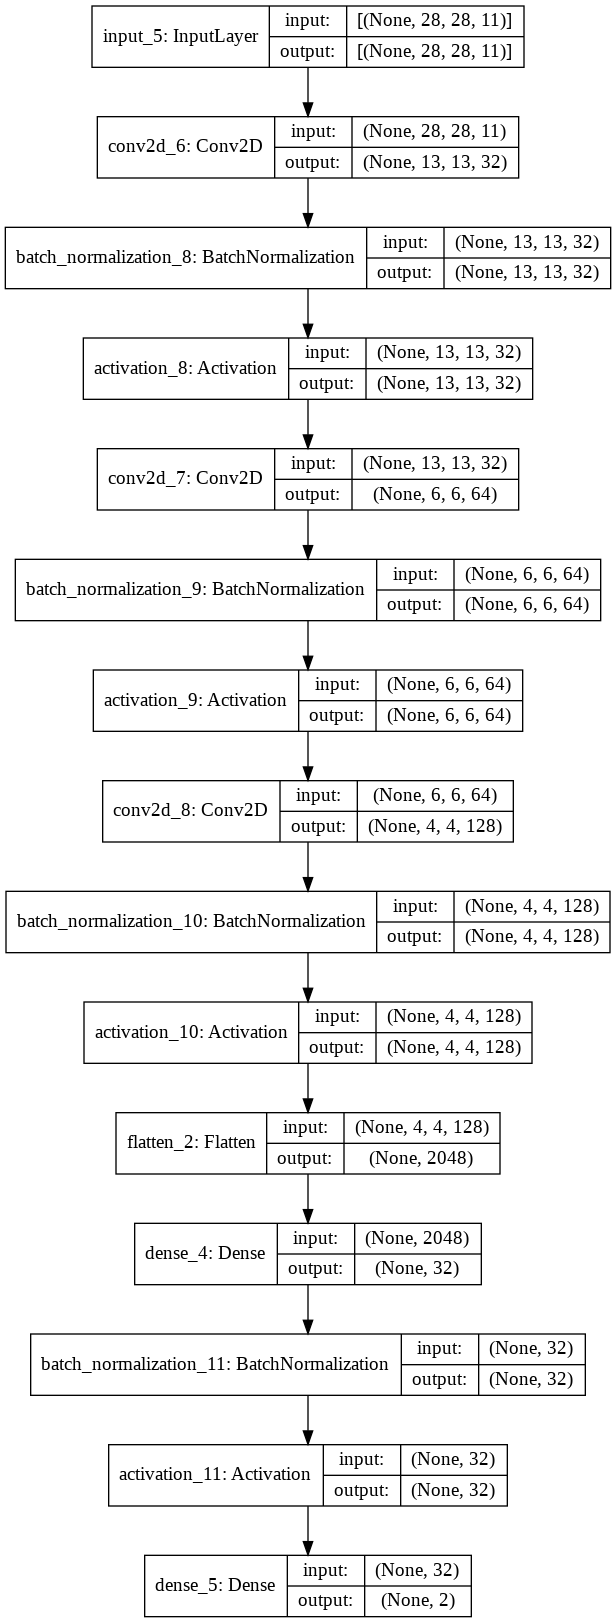

In [ ]:
cae_encoder.summary()
tf.keras.utils.plot_model(cae_encoder, show_shapes=True)

In [ ]:
dec_z = tf.keras.Input(shape = (n_dim, ) , name = 'dec_z_input')
dec_dense_1 = tf.keras.layers.Dense(32)
dec_batch_1 = tf.keras.layers.BatchNormalization()
dec_act_1 = tf.keras.layers.Activation('relu')
dec_dense_2 = tf.keras.layers.Dense(2048)
dec_batch_2 = tf.keras.layers.BatchNormalization()
dec_act_2 = tf.keras.layers.Activation('relu')
dec_reshape = tf.keras.layers.Reshape(target_shape=(4,4,128))
dec_conv_3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2,2),strides=(1,1), padding='same')
dec_batch_3 = tf.keras.layers.BatchNormalization()
dec_act_3 = tf.keras.layers.Activation('relu')
dec_conv_4 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3), strides=(1,1), padding='valid')
dec_batch_4 = tf.keras.layers.BatchNormalization()
dec_act_4 = tf.keras.layers.Activation('relu')
dec_conv_5 = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size=(3,3), strides=(2,2), padding='valid')
dec_batch_5 = tf.keras.layers.BatchNormalization()
dec_act_5 = tf.keras.layers.Activation('relu')
dec_conv_6 = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size=(4,4), strides=(2,2), padding = 'valid')
dec_batch_6 = tf.keras.layers.BatchNormalization()
dec_act_6 = tf.keras.layers.Activation('sigmoid')


x = tf.keras.layers.concatenate([dec_z, con])
x = dec_dense_1(x)
x = dec_batch_1(x)
x = dec_act_1(x)
x = dec_dense_2(x)
x = dec_batch_2(x)
x = dec_act_2(x)
x = dec_reshape(x)
x = dec_conv_3(x)
x = dec_batch_3(x)
x = dec_act_3(x)
x = dec_conv_4(x)
x = dec_batch_4(x)
x = dec_act_4(x)
x = dec_conv_5(x)
x = dec_batch_5(x)
x = dec_act_5(x)
x = dec_conv_6(x)
x = dec_batch_6(x)
y_pred = dec_act_6(x)

cae_decoder = tf.keras.Model(inputs = [dec_z, con], outputs = y_pred, name = 'decoder')

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_z_input (InputLayer)        [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 12)           0           dec_z_input[0][0]                
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 32)           416         concatenate_5[0][0]        

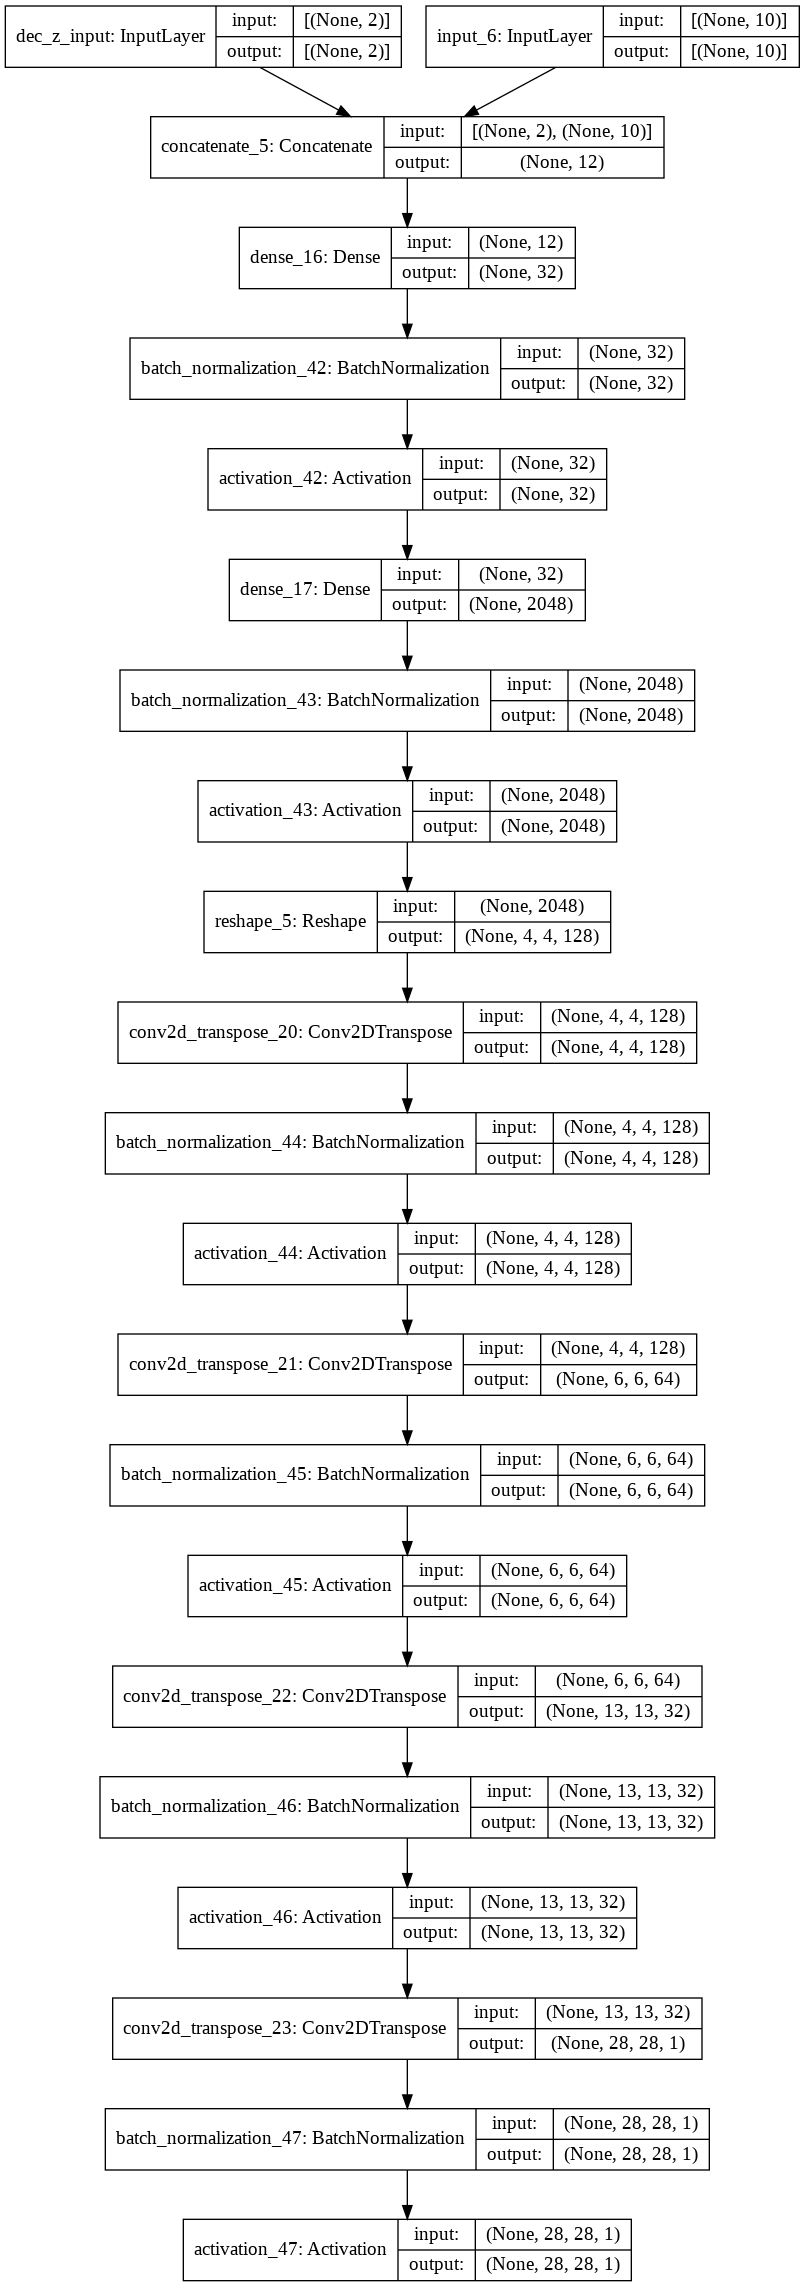

In [ ]:
cae_decoder.summary()
tf.keras.utils.plot_model(cae_decoder, show_shapes=True)

In [ ]:
encoder_out = cae_encoder(img)
decoder_out = cae_decoder([encoder_out,con])
cae = tf.keras.Model([img,con], decoder_out , name = 'CAE')

In [ ]:
results = cae([train_images_con, train_label_onehots])

print('input shape:', train_images_con.shape)
print('output shape:', results.shape)

input shape: (60000, 28, 28, 11)
output shape: (60000, 28, 28, 1)


train_images[idx] 영상에 대한 결과 확인
* ae의 입력 / 출력 가시화

In [ ]:
# 로딩된 MNIST 데이터 가시화

import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(tf.reshape(results[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 네트워크 모델 구조 확인


Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 11)] 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2)            162210      input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    235653      encoder[3][0]                    
                                                                 input_6[0][0]                  

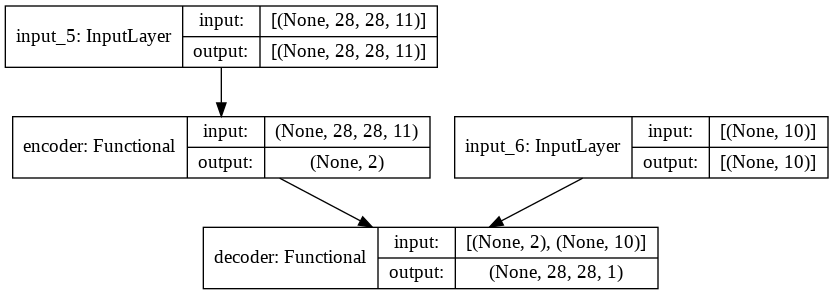

In [ ]:
cae.summary()
tf.keras.utils.plot_model(cae, show_shapes=True)

## 오토인코더 인스턴스 트레이닝



In [ ]:
cae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [ ]:
epochs = 20
batch_size = 100
cae.fit([train_images_con, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 6s 8ms/step - loss: 0.1460 - mae: 0.3523
Epoch 2/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0755 - mae: 0.2414
Epoch 3/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0540 - mae: 0.1905
Epoch 4/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0448 - mae: 0.1617
Epoch 5/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0399 - mae: 0.1428
Epoch 6/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0373 - mae: 0.1299
Epoch 7/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0357 - mae: 0.1203
Epoch 8/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0345 - mae: 0.1126
Epoch 9/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0338 - mae: 0.1069
Epoch 10/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0334 - mae: 0.1023
Epoch 11/20
600/600 [============================

- Dense로 구성한 모델과 loss의 차이는 크지 않다.

## 트레이닝이 끝난 오토인코더를 이용하기
트레이닝이 끝난 오토인코더는 함수로서 작동이 가능하다. 

In [ ]:
results = cae([train_images_con, train_label_onehots])

In [ ]:
def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(tf.reshape(results[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

- 결과를 확인해 보면 어느정도 이미지를 생성하는 것을 확인할 수 있다.

# 디코더를 이용한 Generative Model 구성
디코더 모델을 따로 생성하였기 때문에 전체 Conditional AutoEncoder가 학습을 끝내면 활용 가능하다.


## 디코딩 테스트 입력 결과 확인


인코더 모델을 따로 생성하였기 때문에 학습이 끝나면 활용이 가능하다. 이에 input 이미지가 encoding 된 z값을 확인한다.

In [ ]:
z_vector = cae_encoder(train_images_con)
print(np.shape(z_vector))

(60000, 2)


In [ ]:
def z_show(idx):
  print(z_vector[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
## 디코더의 테스트 입력 설정
## 위의 값과 유사하게 z벡터를 주고, condition을 5로 주어 결과가 비슷하게 나오는지 확인한다.

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1., 0.0, 0.0, 0.0, 0.0]])
  print(z_test)

  img_gen = cae_decoder([z_test, c_test])
  plt.imshow(tf.reshape(img_gen[0] ,(28,28)))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- 결과를 확인해 보면, Encoding 된 이미지의 결과 GT label : 5 (-0.923,0.74) 에 대하여 유사한 z vector 값과 condition을 주어도 5를 생성해냄을 확인할 수 있다. 


### Autoencoder의 인코더가 만들어 내는 representation인 z 값을 조건별로 가시화 한다. 

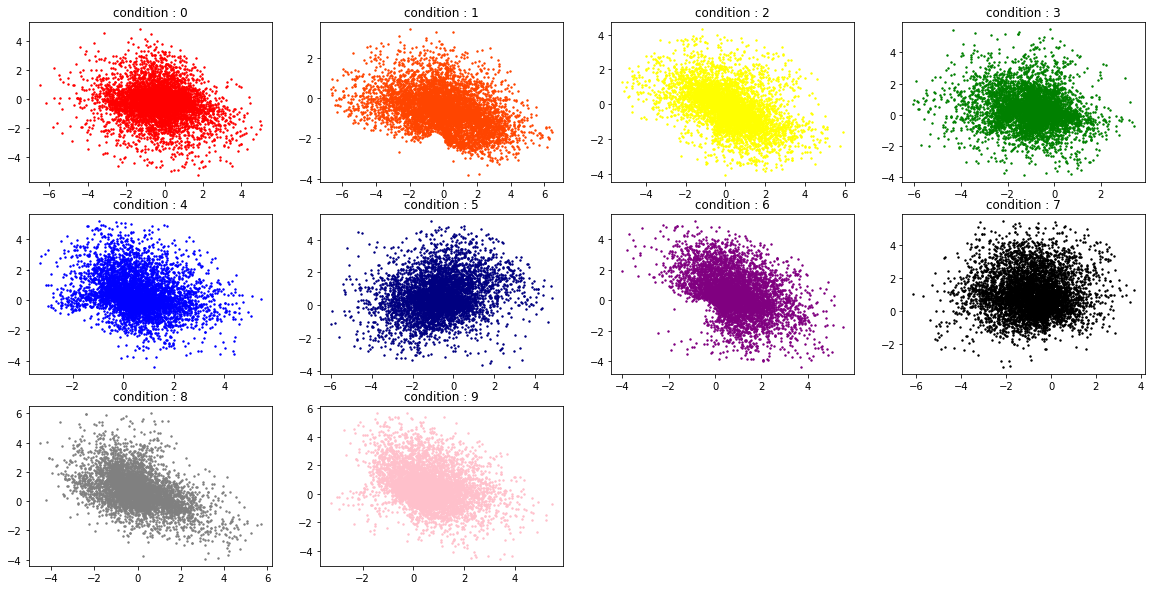

In [ ]:
z_0 = z_vector[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_vector[train_labels==1]
z_2 = z_vector[train_labels==2]
z_3 = z_vector[train_labels==3]
z_4 = z_vector[train_labels==4]
z_5 = z_vector[train_labels==5]
z_6 = z_vector[train_labels==6]
z_7 = z_vector[train_labels==7]
z_8 = z_vector[train_labels==8]
z_9 = z_vector[train_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('condition : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('condition : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('condition : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('condition : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('condition : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('condition : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('condition : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('condition : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('condition : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('condition : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

- 결과를 확인해 보면, 대부분의 z값들이 0을 기준으로 퍼져 나가고 있는것을 확인할 수 있다. 이전 Dense로 구성한 CAE모델은 GT label = 1 인 데이터에 대해서 0 주위로 형성되지 않았지만 Convolution으로 구성한 CAE 모델은 0 주위로 분포가 형성 되어 있음을 확인할 수 있다.

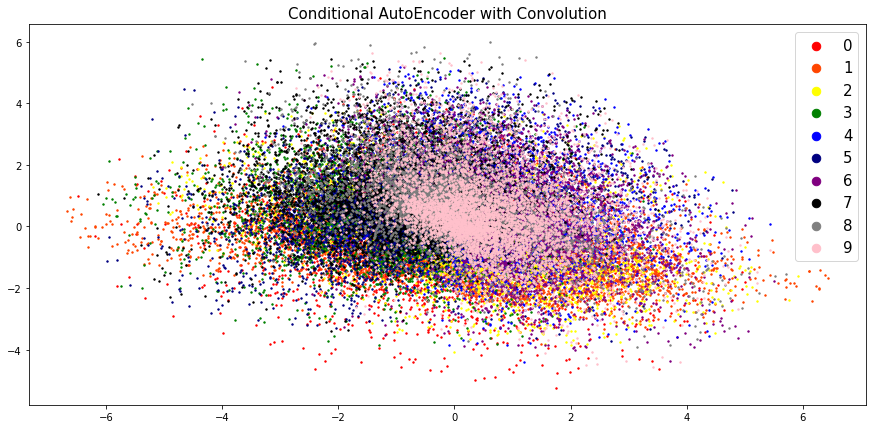

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Conditional AutoEncoder with Convolution', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- 위의 Dense로 구성한 CAE 모델은 가로축으로 [-15, 35] 세로축으로 [-25, 15] 정도로 범위가 형성 되었고, GT label = 1 의 분포는 상당피 퍼져 있었는데, Convolution으로 구성한 CAE 모델은 가로축으로 [-7,7] 세로축으로 [-5,6] 정도의 범위가 형성 되었을 뿐만 아니라 모든 GT label 에 대해서 0을 기준으로 분포가 모이게 형성 되었다.  

In [ ]:
n_dim = 4

In [ ]:
img = tf.keras.Input(shape=(28,28,11)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할

enc_conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides = (2,2), padding = 'valid')
enc_batch_1 = tf.keras.layers.BatchNormalization()
enc_act_1 = tf.keras.layers.Activation('relu')
enc_conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides = (2,2) , padding = 'valid')
enc_batch_2 = tf.keras.layers.BatchNormalization()
enc_act_2 = tf.keras.layers.Activation('relu')
enc_conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides= (1,1), padding = 'valid')
enc_batch_3 = tf.keras.layers.BatchNormalization()
enc_act_3 = tf.keras.layers.Activation('relu')
enc_flatten = tf.keras.layers.Flatten()
enc_dense_4 = tf.keras.layers.Dense(32)
enc_batch_4 = tf.keras.layers.BatchNormalization()
enc_act_4 = tf.keras.layers.Activation('relu')
enc_dense_5 = tf.keras.layers.Dense(n_dim)


x = enc_conv_1(img)
x = enc_batch_1(x)
x = enc_act_1(x)
x = enc_conv_2(x)
x = enc_batch_2(x)
x = enc_act_2(x)
x = enc_conv_3(x)
x = enc_batch_3(x)
x = enc_act_3(x)
x = enc_flatten(x)
x = enc_dense_4(x)
x = enc_batch_4(x)
x = enc_act_4(x)
z = enc_dense_5(x)

cae_encoder = tf.keras.Model(inputs = img, outputs = z, name = 'encoder')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 11)]      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 32)        3200      
_________________________________________________________________
batch_normalization_48 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
activation_48 (Activation)   (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
batch_normalization_49 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
activation_49 (Activation)   (None, 6, 6, 64)          0   

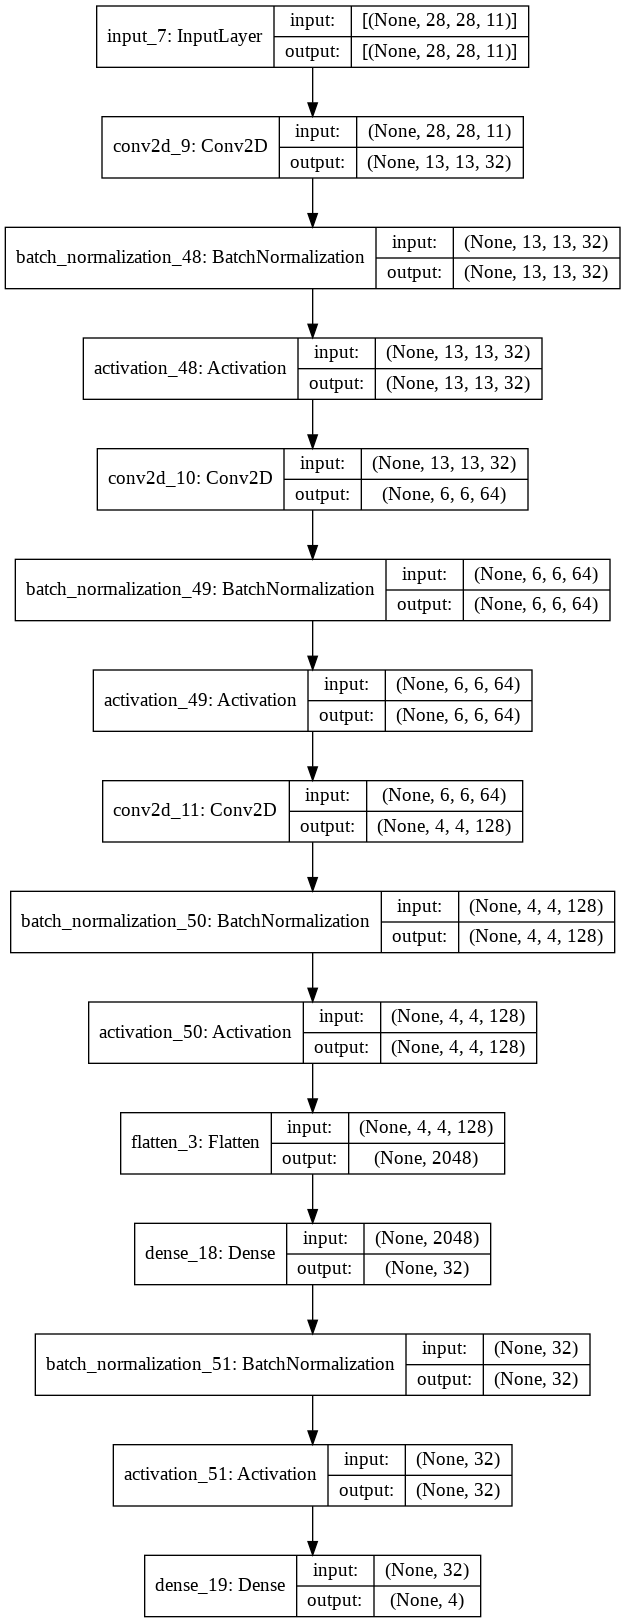

In [ ]:
cae_encoder.summary()
tf.keras.utils.plot_model(cae_encoder, show_shapes=True)

In [ ]:
dec_z = tf.keras.Input(shape = (n_dim, ) , name = 'dec_z_input')
dec_dense_1 = tf.keras.layers.Dense(32)
dec_batch_1 = tf.keras.layers.BatchNormalization()
dec_act_1 = tf.keras.layers.Activation('relu')
dec_dense_2 = tf.keras.layers.Dense(2048)
dec_batch_2 = tf.keras.layers.BatchNormalization()
dec_act_2 = tf.keras.layers.Activation('relu')
dec_reshape = tf.keras.layers.Reshape(target_shape=(4,4,128))
dec_conv_3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2,2),strides=(1,1), padding='same')
dec_batch_3 = tf.keras.layers.BatchNormalization()
dec_act_3 = tf.keras.layers.Activation('relu')
dec_conv_4 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3), strides=(1,1), padding='valid')
dec_batch_4 = tf.keras.layers.BatchNormalization()
dec_act_4 = tf.keras.layers.Activation('relu')
dec_conv_5 = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size=(3,3), strides=(2,2), padding='valid')
dec_batch_5 = tf.keras.layers.BatchNormalization()
dec_act_5 = tf.keras.layers.Activation('relu')
dec_conv_6 = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size=(4,4), strides=(2,2), padding = 'valid')
dec_batch_6 = tf.keras.layers.BatchNormalization()
dec_act_6 = tf.keras.layers.Activation('sigmoid')


x = tf.keras.layers.concatenate([dec_z, con])
x = dec_dense_1(x)
x = dec_batch_1(x)
x = dec_act_1(x)
x = dec_dense_2(x)
x = dec_batch_2(x)
x = dec_act_2(x)
x = dec_reshape(x)
x = dec_conv_3(x)
x = dec_batch_3(x)
x = dec_act_3(x)
x = dec_conv_4(x)
x = dec_batch_4(x)
x = dec_act_4(x)
x = dec_conv_5(x)
x = dec_batch_5(x)
x = dec_act_5(x)
x = dec_conv_6(x)
x = dec_batch_6(x)
y_pred = dec_act_6(x)

cae_decoder = tf.keras.Model(inputs = [dec_z, con], outputs = y_pred, name = 'decoder')

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_z_input (InputLayer)        [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 14)           0           dec_z_input[0][0]                
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 32)           480         concatenate_6[0][0]        

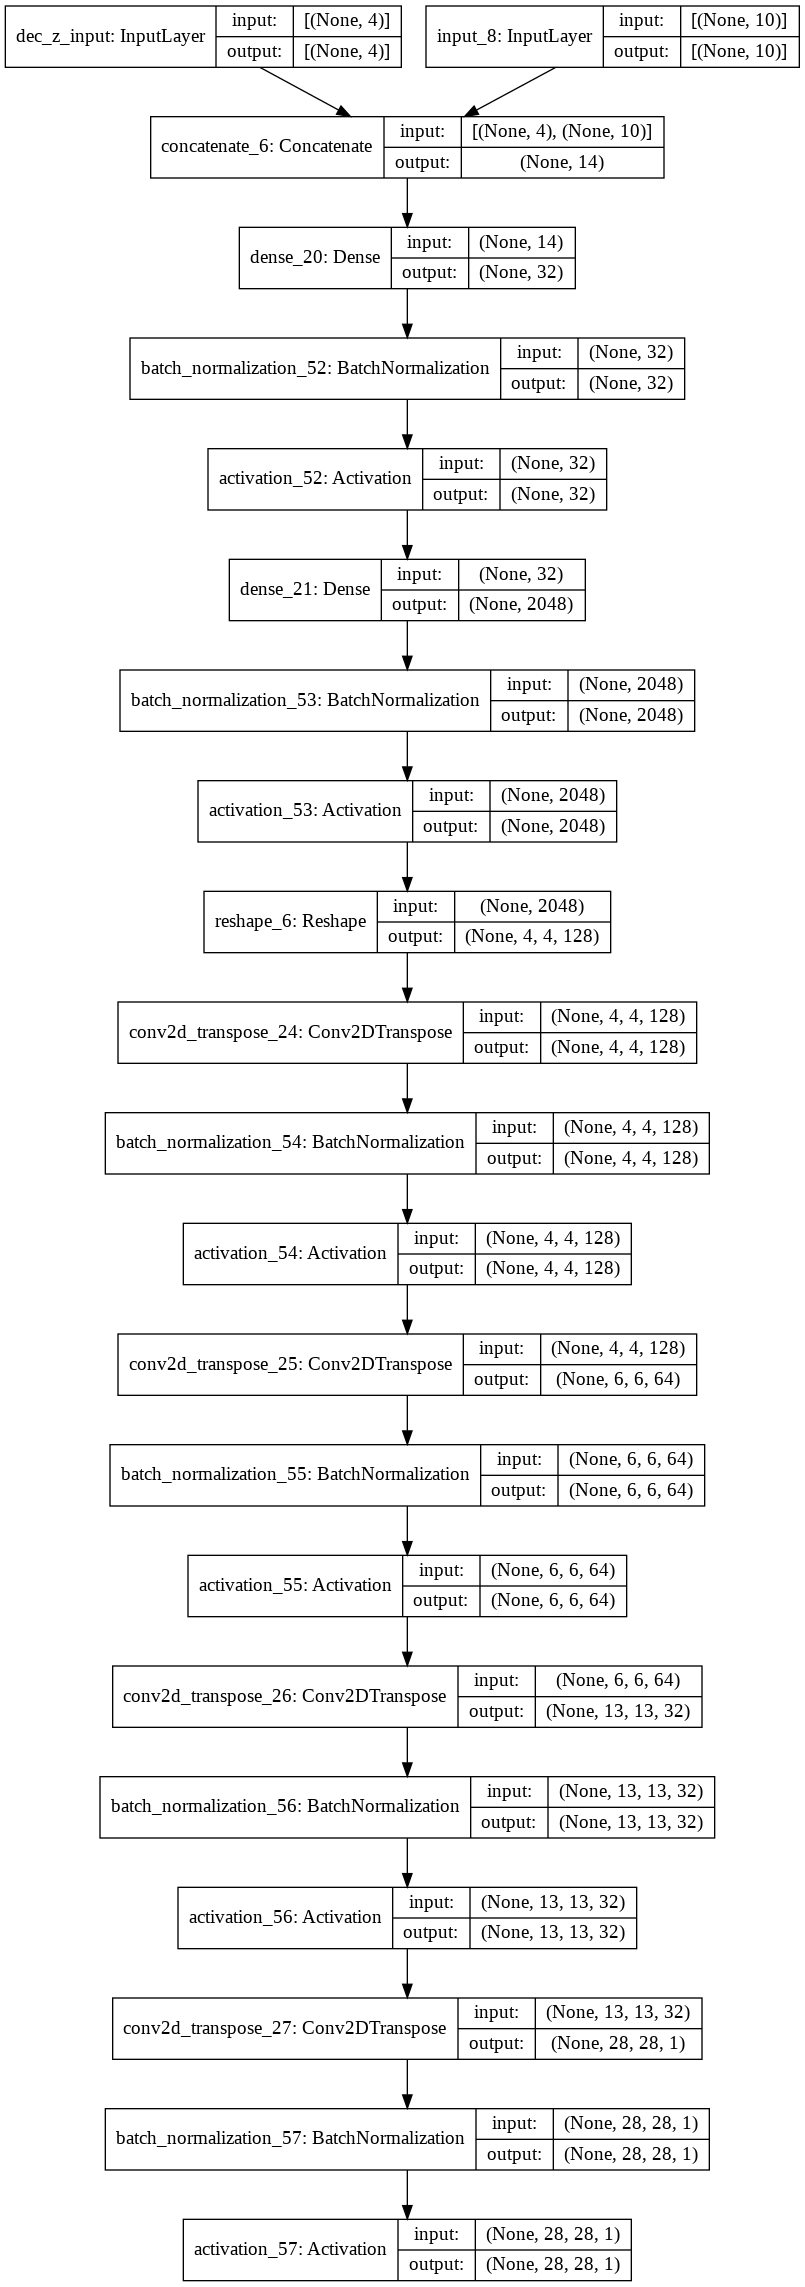

In [ ]:
cae_decoder.summary()
tf.keras.utils.plot_model(cae_decoder, show_shapes=True)

In [ ]:
encoder_out = cae_encoder(img)
decoder_out = cae_decoder([encoder_out,con])
cae = tf.keras.Model([img,con], decoder_out , name = 'CAE')

## 훈련 전 , 네트워크 모델을 함수로서 활용

In [ ]:
results = cae([train_images_con, train_label_onehots])

print('input shape:', train_images_con.shape)
print('output shape:', results.shape)

input shape: (60000, 28, 28, 11)
output shape: (60000, 28, 28, 1)


In [ ]:
# 로딩된 MNIST 데이터 가시화

import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(tf.reshape(results[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 네트워크 모델 구조 확인

Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 11)] 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 4)            162276      input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    235717      encoder[0][0]                    
                                                                 input_8[0][0]                  

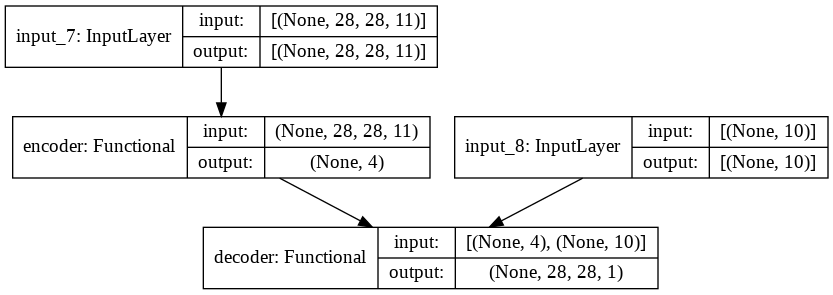

In [ ]:
cae.summary()
tf.keras.utils.plot_model(cae, show_shapes=True)

## 오토인코더 인스턴스 트레이닝


In [ ]:
cae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [ ]:
epochs = 20
batch_size = 100
cae.fit([train_images_con, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 6s 8ms/step - loss: 0.1429 - mae: 0.3495
Epoch 2/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0681 - mae: 0.2323
Epoch 3/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0459 - mae: 0.1786
Epoch 4/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0362 - mae: 0.1476
Epoch 5/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0315 - mae: 0.1280
Epoch 6/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0287 - mae: 0.1144
Epoch 7/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0270 - mae: 0.1042
Epoch 8/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0259 - mae: 0.0967
Epoch 9/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0251 - mae: 0.0905
Epoch 10/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0245 - mae: 0.0857
Epoch 11/20
600/600 [============================

- latent vector의 차원을 늘리니 학습이 보다 더 잘된 것을 확인할 수 있다.

## 트레이닝이 끝난 오토인코더를 이용하기
트레이닝이 끝난 오토인코더는 함수로서 작동이 가능하다. 

In [ ]:
results = cae([train_images_con, train_label_onehots])

In [ ]:
def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(tf.reshape(results[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

# 디코더를 이용한 Generative Model 구성
디코더 모델을 따로 생성하였기 때문에 전체 Conditional AutoEncoder가 학습을 끝내면 활용 가능하다.

## 디코딩 테스트 입력 결과 확인
* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.

In [ ]:
z_vector = cae_encoder(train_images_con)
print(np.shape(z_vector))

(60000, 4)


In [ ]:
def z_show(idx):
  print(z_vector[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
## 디코더의 테스트 입력 설정
## 위의 값과 유사하게 z벡터를 주고, condition을 5로 주어 결과가 비슷하게 나오는지 확인한다.

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)
z=widgets.FloatSlider(min=-5.0, max=5.0)
w=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v,z,w])

def z_test(u, v, z, w):
  z_test = np.array([[u,v,z,w]])  
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1., 0.0, 0.0, 0.0, 0.0]])
  print(z_test)

  img_gen = cae_decoder([z_test, c_test])  # decoder 모델을 따로 두었기 때문에 바로 사용 가능하다.
  plt.imshow(tf.reshape(img_gen[0] ,(28,28)))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v,'z':z,'w':w})

display(ui, out)

Output()

- 결과를 확인해 보면, Encoding 된 이미지의 결과 GT label : 5 (1.46,0.11,-0.046,0.036) 에 대하여 유사한 z vector 값과 condition을 주어도 5를 생성해냄을 확인할 수 있다.

## Autoencoder의 인코더가 만들어 내는 representation인 z 값을 조건별로 가시화 한다. 

- 인코딩된 z vector가 4차원이기 때문에 tsne를 통해 차원을 줄인 후 가시화를 진행한다.

In [ ]:
from sklearn.manifold import TSNE      # sklearn에서 제공하는 TSNE를 사용한다

tsne = TSNE(n_components = 2)
transformed_z  = tsne.fit_transform(z_vector)

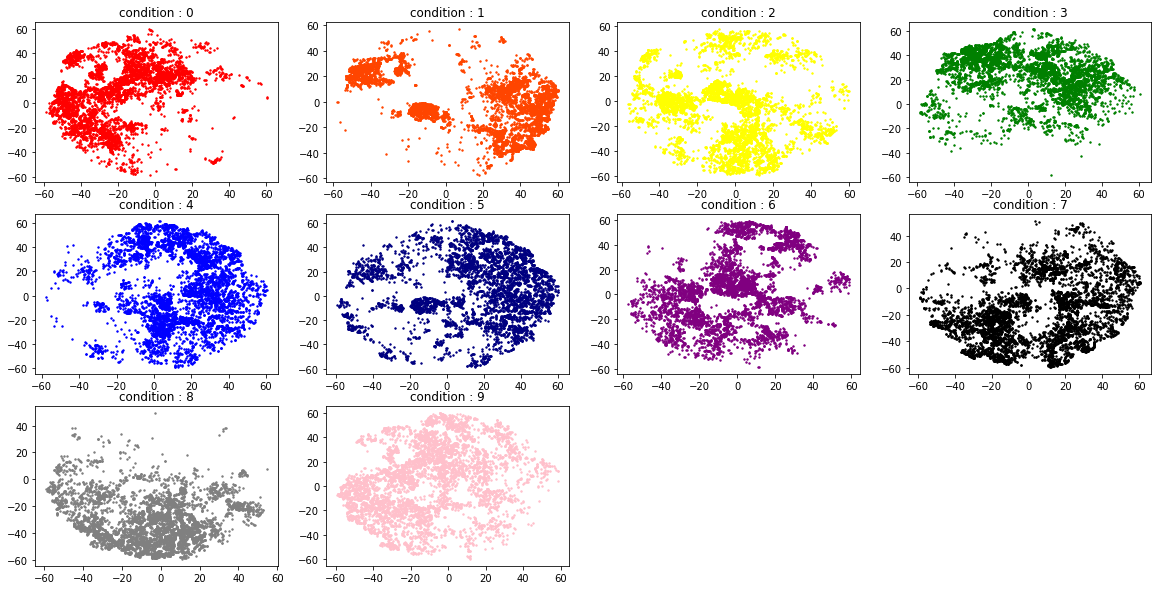

In [ ]:
z_0 = transformed_z[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = transformed_z[train_labels==1]
z_2 = transformed_z[train_labels==2]
z_3 = transformed_z[train_labels==3]
z_4 = transformed_z[train_labels==4]
z_5 = transformed_z[train_labels==5]
z_6 = transformed_z[train_labels==6]
z_7 = transformed_z[train_labels==7]
z_8 = transformed_z[train_labels==8]
z_9 = transformed_z[train_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('condition : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('condition : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('condition : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('condition : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('condition : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('condition : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('condition : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('condition : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('condition : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('condition : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

- z_vector 를 tsne를 통해 2차원을 줄인 결과를 보면, 대부분의 z 값들이 굉장히 큰 범위에 분포함을 확인할 수 있다.

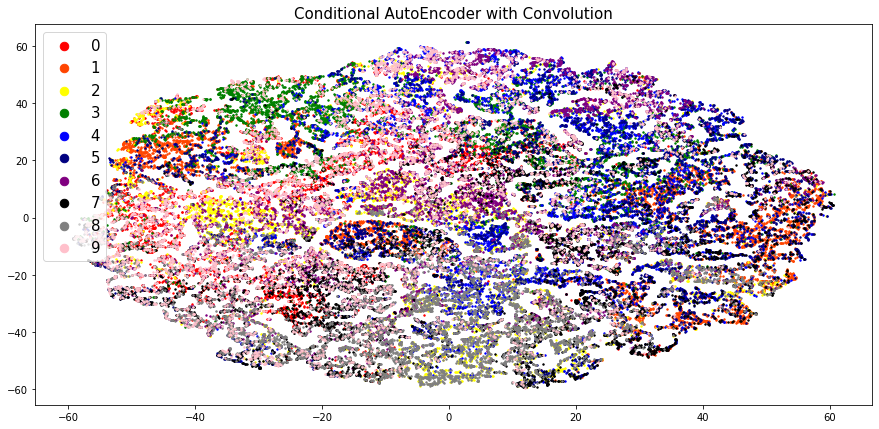

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Conditional AutoEncoder with Convolution', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

In [ ]:
print(np.min(z_vector[:,0]), np.max(z_vector[:,0]))
print(np.min(z_vector[:,1]), np.max(z_vector[:,1]))
print(np.min(z_vector[:,2]), np.max(z_vector[:,2]))
print(np.min(z_vector[:,3]), np.max(z_vector[:,3]))


-4.6925297 5.232171
-5.5213575 4.7768764
-5.3225436 5.9667416
-4.796695 5.201115


In [ ]:
print(np.min(transformed_z[:,0]), np.max(transformed_z[:,0]))
print(np.min(transformed_z[:,1]), np.max(transformed_z[:,1]))

-59.168404 60.688538
-59.337215 61.404552


- 이전 n_dim을 2차원으로 했을 경우보다 굉장히 큰 범위에 분포해 있는것을 확인할 수 있다. 이는 tsne로 2차원으로 줄이면서 값들이 굉장히 커졌기 때문이다. 위의 결과를 보면 z_vector의 각 차원의 범위를 보면, [-5,5] 사이에 분포되어 있는데, tsne로 차원을 축소하여 결과를 확인하니 [-59,61] 사이에 분포하게 되었다.

## Denoising Conditional AutoEncoder

-  Vision을 연구하는 분야에서는 고의적으로 input data에 noise를 추가하고, 추가된 노이즈를 토대로 학습된 데이터에서 나오는 결과값이, 내가 노이즈를 삽입하기 전의 pure input 값인지를 확인한다.

- 이에 <a href="http://www.iro.umontreal.ca/~vincentp/Publications/denoising_autoencoders_tr1316.pdf">[Vincent 08]</a> 의 논문에서 Denoising AutoEncoder를 제안하였는데, 이 논문의 내용은 훌륭한 대표성을 가지는 데이터는 종속적인 데이터에서 안정적인 구조의 데이터를 뽑아내는 것이다. 라고 설명 하였다.

- 따라서 기존 n_dim = 2인 모델에 노이즈를 추가하여 Denoising Conditional AutoEncoder를 실험해 보겠다.

In [ ]:
n_dim = 2

noise_factor = 0.3 # 노이즈를 얼마나 적용할지에 대한 하이퍼 파라미터 이다.

train_noisy = noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = train_images_con.shape) # 평균이 0이고 분산이 1 인 Gaussian Distribution에서 노이즈 생성 

train_images_con_noisy = train_images_con + train_noisy
train_images_con_noisy = np.clip(train_images_con_noisy, 0., 1.) # 기존에 데이터가 0~1 사이 값을 가지고 있기 때문에 noise를 추가한 후 0~1사이 값을 가지게 함 하이퍼 파라미터 이다.


노이즈 추가전, 추가 후 이미지 확인

In [ ]:
import matplotlib.pyplot as plt

train_images_noise = train_images + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = train_images.shape)
train_images_noise = np.clip(train_images_noise, 0., 1.) 

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(train_images_noise[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
img = tf.keras.Input(shape=(28,28,11)) # TF 1.x의 placeholder 역할
con = tf.keras.Input(shape=(10,))   # TF 1.x의 placeholder 역할

enc_conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides = (2,2), padding = 'valid')
enc_batch_1 = tf.keras.layers.BatchNormalization()
enc_act_1 = tf.keras.layers.Activation('relu')
enc_conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides = (2,2) , padding = 'valid')
enc_batch_2 = tf.keras.layers.BatchNormalization()
enc_act_2 = tf.keras.layers.Activation('relu')
enc_conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides= (1,1), padding = 'valid')
enc_batch_3 = tf.keras.layers.BatchNormalization()
enc_act_3 = tf.keras.layers.Activation('relu')
enc_flatten = tf.keras.layers.Flatten()
enc_dense_4 = tf.keras.layers.Dense(32)
enc_batch_4 = tf.keras.layers.BatchNormalization()
enc_act_4 = tf.keras.layers.Activation('relu')
enc_dense_5 = tf.keras.layers.Dense(n_dim)


x = enc_conv_1(img)
x = enc_batch_1(x)
x = enc_act_1(x)
x = enc_conv_2(x)
x = enc_batch_2(x)
x = enc_act_2(x)
x = enc_conv_3(x)
x = enc_batch_3(x)
x = enc_act_3(x)
x = enc_flatten(x)
x = enc_dense_4(x)
x = enc_batch_4(x)
x = enc_act_4(x)
z = enc_dense_5(x)

de_cae_encoder = tf.keras.Model(inputs = img, outputs = z, name = 'encoder')

In [ ]:
dec_z = tf.keras.Input(shape = (n_dim, ) , name = 'dec_z_input')
dec_dense_1 = tf.keras.layers.Dense(32)
dec_batch_1 = tf.keras.layers.BatchNormalization()
dec_act_1 = tf.keras.layers.Activation('relu')
dec_dense_2 = tf.keras.layers.Dense(2048)
dec_batch_2 = tf.keras.layers.BatchNormalization()
dec_act_2 = tf.keras.layers.Activation('relu')
dec_reshape = tf.keras.layers.Reshape(target_shape=(4,4,128))
dec_conv_3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2,2),strides=(1,1), padding='same')
dec_batch_3 = tf.keras.layers.BatchNormalization()
dec_act_3 = tf.keras.layers.Activation('relu')
dec_conv_4 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3), strides=(1,1), padding='valid')
dec_batch_4 = tf.keras.layers.BatchNormalization()
dec_act_4 = tf.keras.layers.Activation('relu')
dec_conv_5 = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size=(3,3), strides=(2,2), padding='valid')
dec_batch_5 = tf.keras.layers.BatchNormalization()
dec_act_5 = tf.keras.layers.Activation('relu')
dec_conv_6 = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size=(4,4), strides=(2,2), padding = 'valid')
dec_batch_6 = tf.keras.layers.BatchNormalization()
dec_act_6 = tf.keras.layers.Activation('sigmoid')


x = tf.keras.layers.concatenate([dec_z, con])
x = dec_dense_1(x)
x = dec_batch_1(x)
x = dec_act_1(x)
x = dec_dense_2(x)
x = dec_batch_2(x)
x = dec_act_2(x)
x = dec_reshape(x)
x = dec_conv_3(x)
x = dec_batch_3(x)
x = dec_act_3(x)
x = dec_conv_4(x)
x = dec_batch_4(x)
x = dec_act_4(x)
x = dec_conv_5(x)
x = dec_batch_5(x)
x = dec_act_5(x)
x = dec_conv_6(x)
x = dec_batch_6(x)
y_pred = dec_act_6(x)

de_cae_decoder = tf.keras.Model(inputs = [dec_z, con], outputs = y_pred, name = 'decoder')

In [ ]:
encoder_out = de_cae_encoder(img)
decoder_out = de_cae_decoder([encoder_out,con])
de_cae = tf.keras.Model([img,con], decoder_out , name = 'CAE')

In [ ]:
results = de_cae([train_images_con_noisy, train_label_onehots])

print('input shape:', train_images_con_noisy.shape)
print('output shape:', results.shape)

input shape: (60000, 28, 28, 11)
output shape: (60000, 28, 28, 1)


In [ ]:
def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images_noise[idx])
  plt.subplot(122)
  plt.imshow(tf.reshape(results[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 11)] 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2)            162210      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    235653      encoder[0][0]                    
                                                                 input_4[0][0]                  

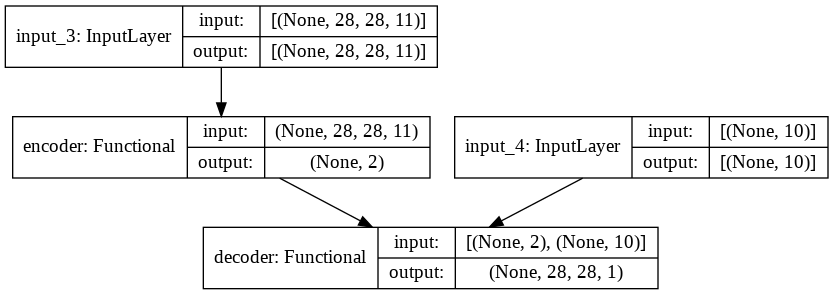

In [ ]:
de_cae.summary()
tf.keras.utils.plot_model(de_cae, show_shapes=True)

In [ ]:
de_cae.compile(optimizer='adam',
           loss='mse',
           metrics=['mae'])

In [ ]:
epochs = 20
batch_size = 100
de_cae.fit([train_images_con_noisy, train_label_onehots], train_images, epochs=epochs, batch_size=batch_size) # 학습시 주의 사항 ! X에는 noise가 있는 이미지를 넣고 Y에는 원본 이미지를 넣어야함

Epoch 1/20
600/600 [==============================] - 7s 9ms/step - loss: 0.1465 - mae: 0.3529
Epoch 2/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0757 - mae: 0.2417
Epoch 3/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0544 - mae: 0.1912
Epoch 4/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0450 - mae: 0.1621
Epoch 5/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0404 - mae: 0.1437
Epoch 6/20
600/600 [==============================] - 5s 9ms/step - loss: 0.0375 - mae: 0.1302
Epoch 7/20
600/600 [==============================] - 5s 9ms/step - loss: 0.0359 - mae: 0.1207
Epoch 8/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0348 - mae: 0.1132
Epoch 9/20
600/600 [==============================] - 5s 9ms/step - loss: 0.0341 - mae: 0.1074
Epoch 10/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0336 - mae: 0.1028
Epoch 11/20
600/600 [============================

- loss, mae는 conditional ae와 유사하다.

## 트레이닝이 끝난 오토인코더를 이용하기

In [ ]:
results = de_cae([train_images_con_noisy, train_label_onehots])

In [ ]:
def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images_noise[idx])
  plt.subplot(122)
  plt.imshow(tf.reshape(results[idx],(28,28)))
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

- X 데이터에 노이즈가 포함 되어 있음에도 불구하고 이미지를 잘 생성해냄을 확인할 수 있다.

# 디코더를 이용한 Generative Model 구성

디코더 모델을 따로 생성하였기 때문에 전체 Conditional AutoEncoder가 학습을 끝내면 활용 가능하다.

## 디코딩 테스트 입력 결과 확인

- 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.

In [ ]:
z_vector = de_cae_encoder(train_images_con_noisy)
print(np.shape(z_vector))

(60000, 2)


In [ ]:
def z_show(idx):
  print(z_vector[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
## 디코더의 테스트 입력 설정
## 위의 값과 유사하게 z벡터를 주고, condition을 5로 주어 결과가 비슷하게 나오는지 확인한다.

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1., 0.0, 0.0, 0.0, 0.0]])
  print(z_test)

  img_gen = de_cae_decoder([z_test, c_test])  # decoder 모델을 따로 두었기 때문에 바로 사용 가능하다.
  plt.imshow(tf.reshape(img_gen[0] ,(28,28)))
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

결과를 확인해 보면, Encoding 된 이미지의 결과 GT label : 5 (1.371,-0.189) 에 대하여 유사한 z vector 값과 condition을 주어도 5를 생성해냄을 확인할 수 있다.

## Autoencoder의 인코더가 만들어 내는 representation인 z 값을 조건별로 가시화 한다.


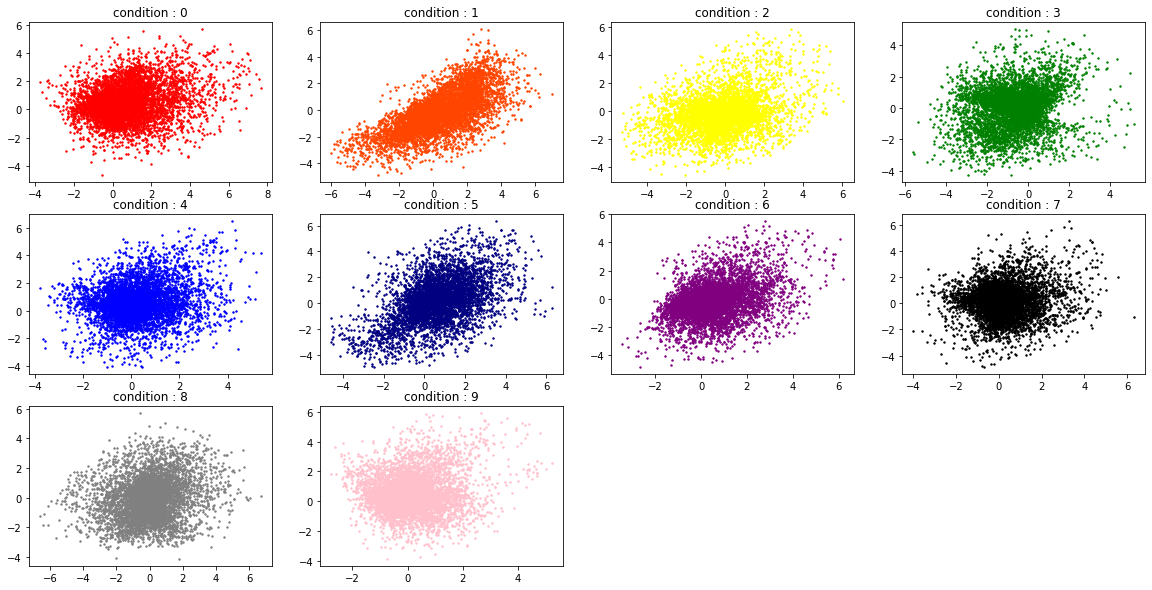

In [ ]:
z_0 = z_vector[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_vector[train_labels==1]
z_2 = z_vector[train_labels==2]
z_3 = z_vector[train_labels==3]
z_4 = z_vector[train_labels==4]
z_5 = z_vector[train_labels==5]
z_6 = z_vector[train_labels==6]
z_7 = z_vector[train_labels==7]
z_8 = z_vector[train_labels==8]
z_9 = z_vector[train_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('condition : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('condition : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('condition : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('condition : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('condition : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('condition : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('condition : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('condition : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('condition : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('condition : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

-  결과를 확인해 보면, 대부분의 z값들이 0을 기준으로 퍼져 나가고 있는것을 확인할 수 있다. 

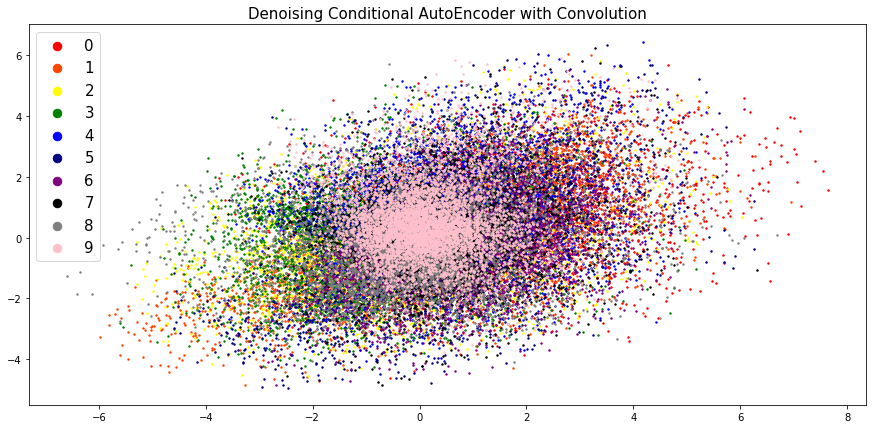

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Denoising Conditional AutoEncoder with Convolution', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- Denoising CAE 모델은 가로축으로 [-7,7] 세로축으로 [-5,6] 정도의 범위가 형성 되었을 뿐만 아니라 모든 GT label 에 대해서 0을 기준으로 분포가 모이게 형성 되었다. 또한 위의 CAE with Convolution (n_dim = 2) 인 모델 보다 0 주위에 더 잘 분포해 있는것을 확인할 수 있다.